# Speech Emotion Recognition 


### English Audio Data With 16 Class 8 Emotion for both Gender

## Importing the required libraries

In [1]:
import os
import random
import sys

import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io.wavfile

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical

from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

Using TensorFlow backend.


##  Data
#### Data Set: [The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)](https://zenodo.org/record/1188976)

In [2]:
# Data Directory
dir_list = os.listdir('datasets/Audio_Speech_Actors_01-24/')
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [3]:
# Creating the DataFrame
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('datasets/Audio_Speech_Actors_01-24/' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = 'datasets/Audio_Speech_Actors_01-24/' + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1

In [4]:
print (len(data_df))
data_df.head()

1440


,path,source,actor,gender,intensity,statement,repetition,emotion
0,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,1,1,0,8
1,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,0,0,8
2,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,1,0,5
3,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,1,1,6
4,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,1,0,1,6


## Plotting audio file spectrogram

In [5]:
filename = data_df.path[73]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

datasets/Audio_Speech_Actors_01-24/Actor_02/03-01-02-01-02-01-02.wav


(22050, array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.6774069e-05,
        2.8452225e-05, 0.0000000e+00], dtype=float32))

In [6]:
len(samples), sample_rate

(84610, 22050)

In [7]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [8]:
sample_rate/ len(samples)

0.26060749320411297

Text(0.5, 0, 'Seconds')

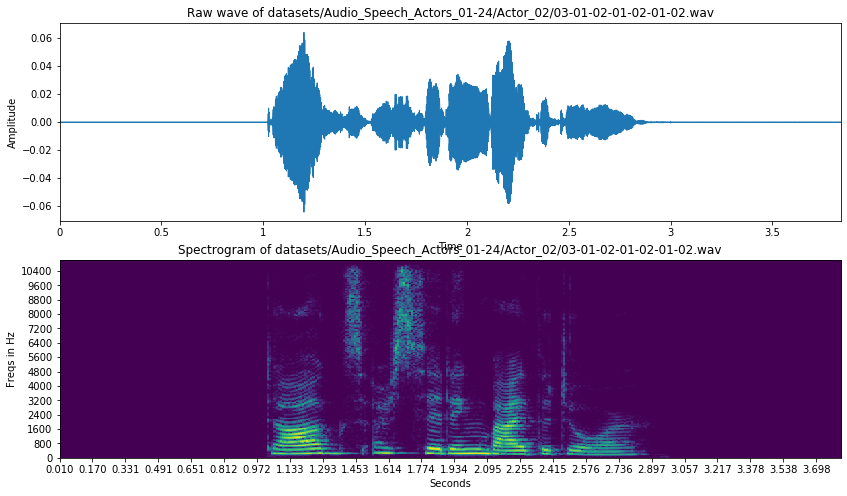

In [9]:
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
librosa.display.waveplot(samples, sr=sample_rate)
#plt.savefig('female__calm.png')
ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [10]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

In [11]:
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([ 2.7743695e-07, -4.0183238e-07, -2.5347426e-05, ...,
        -3.3815985e-04, -1.6680225e-04, -9.7163822e-05], dtype=float32),
 array([22016, 63488]))

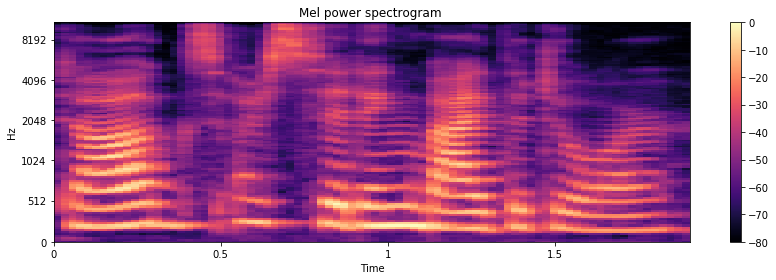

In [12]:
# Plotting Mel Power Spectrogram
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar()
plt.tight_layout()

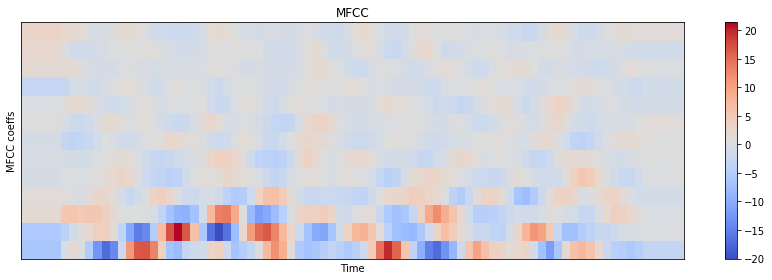

In [13]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [14]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [15]:
# Silence trimmed Sound by librosa.effects.trim()
ipd.Audio(aa, rate=sample_rate)

In [16]:
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

## Labled emotion

In [17]:

label_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label_list.append(data_df.gender[i]  + lb)
    
len(label_list)

1440

In [18]:
data_df['label'] = label_list
data_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,1,1,0,8,male_surprised
1,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,0,0,8,male_surprised
2,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,1,0,5,male_angry
3,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,1,1,6,male_fearful
4,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,1,0,1,6,male_fearful


In [19]:
data_df.label.unique()

array(['male_surprised', 'male_angry', 'male_fearful', 'male_disgust',
       'male_sad', 'male_happy', 'male_calm', 'male_neutral',
       'female_fearful', 'female_angry', 'female_sad', 'female_disgust',
       'female_surprised', 'female_happy', 'female_calm',
       'female_neutral'], dtype=object)

####  Plotting the emotion distribution

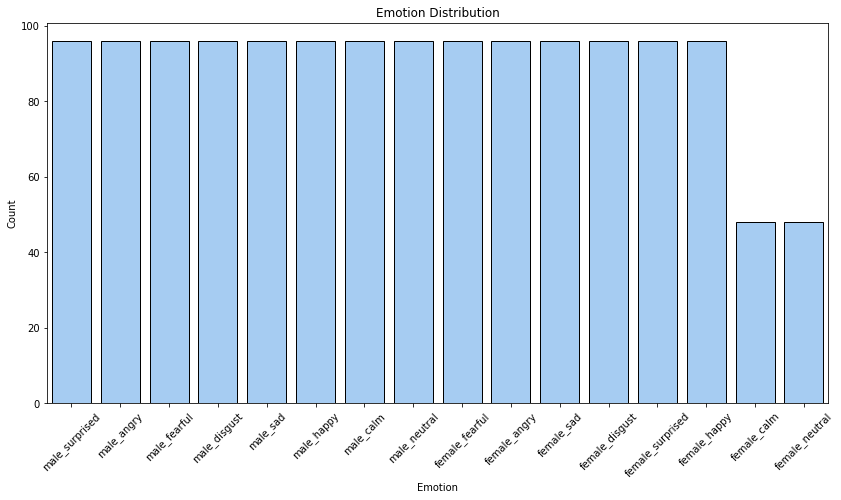

In [20]:
tmp_df = pd.DataFrame()
tmp_df['Emotion'] = list(data_df.label.unique())
tmp_df['Count'] = list(data_df.label.value_counts())
fig, ax = plt.subplots(figsize=(14, 7))
ax = sns.barplot(x="Emotion", y='Count',color='#99ccff', ec='black' ,data=tmp_df)
ax.set_title("Emotion Distribution")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45);

# Data Splitting

In [21]:
data2_df = data_df.copy()

# Two Female Actor and Two Male Actor 

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 23]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp2, tmp3, tmp4],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()



1200


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,1,1,0,8,male_surprised
1,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,0,0,8,male_surprised
2,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,1,0,5,male_angry
3,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,0,1,1,6,male_fearful
4,datasets/Audio_Speech_Actors_01-24/Actor_01/03...,1,1,male,1,0,1,6,male_fearful


In [22]:
print (len(data3_df))
data3_df.head()

240


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,datasets/Audio_Speech_Actors_01-24/Actor_21/03...,1,21,male,1,0,0,8,male_surprised
1,datasets/Audio_Speech_Actors_01-24/Actor_21/03...,1,21,male,0,1,0,8,male_surprised
2,datasets/Audio_Speech_Actors_01-24/Actor_21/03...,1,21,male,0,0,1,6,male_fearful
3,datasets/Audio_Speech_Actors_01-24/Actor_21/03...,1,21,male,0,0,0,5,male_angry
4,datasets/Audio_Speech_Actors_01-24/Actor_21/03...,1,21,male,1,1,0,5,male_angry


# Getting Audio feature using librosa

In [23]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',sr=16000,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|██████████| 1200/1200 [00:40<00:00, 29.52it/s]


In [24]:
data.head()

,feature
0,"[-61.70219, -61.70219, -61.70219, -61.70219, -..."
1,"[-63.314148, -63.314148, -63.314148, -63.31414..."
2,"[-57.457523, -56.856003, -57.73687, -58.498684..."
3,"[-64.29782, -64.29782, -63.25962, -64.23735, -..."
4,"[-43.98741, -44.31096, -44.818047, -45.231487,..."


In [25]:
feature_df = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label

In [26]:
feature_df.head()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,-61.702190,-61.702190,-61.702190,-61.702190,-61.702190,-61.702190,-61.702190,-61.702190,-61.702190,-61.702190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-63.314148,-63.314148,-63.314148,-63.314148,-63.314148,-63.314148,-63.314148,-63.314148,-63.314148,-63.314148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-57.457523,-56.856003,-57.736870,-58.498684,-58.498684,-58.498684,-58.329227,-57.496426,-57.612385,-56.518661,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-64.297821,-64.297821,-63.259621,-64.237350,-64.297821,-64.297821,-64.297821,-64.297821,-63.423653,-58.530704,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-43.987411,-44.310959,-44.818047,-45.231487,-45.295975,-45.097656,-45.114861,-44.829300,-45.086941,-42.232491,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
labeled_df = pd.concat([feature_df,labels], axis=1)

In [28]:
final_df = labeled_df.rename(index=str, columns={"0": "label"})
len(final_df)

1200

In [29]:
final_df.head()

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,label
0,-61.702190,-61.702190,-61.702190,-61.702190,-61.702190,-61.702190,-61.702190,-61.702190,-61.702190,-61.702190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_surprised
1,-63.314148,-63.314148,-63.314148,-63.314148,-63.314148,-63.314148,-63.314148,-63.314148,-63.314148,-63.314148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_surprised
2,-57.457523,-56.856003,-57.736870,-58.498684,-58.498684,-58.498684,-58.329227,-57.496426,-57.612385,-56.518661,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_angry
3,-64.297821,-64.297821,-63.259621,-64.237350,-64.297821,-64.297821,-64.297821,-64.297821,-63.423653,-58.530704,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_fearful
4,-43.987411,-44.310959,-44.818047,-45.231487,-45.295975,-45.097656,-45.114861,-44.829300,-45.086941,-42.232491,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,male_fearful


In [30]:
final_df.isnull().sum().sum()

60167

In [31]:
final_df = final_df.fillna(0)
final_df.head()

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,label
0,-61.702190,-61.702190,-61.702190,-61.702190,-61.702190,-61.702190,-61.702190,-61.702190,-61.702190,-61.702190,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_surprised
1,-63.314148,-63.314148,-63.314148,-63.314148,-63.314148,-63.314148,-63.314148,-63.314148,-63.314148,-63.314148,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_surprised
2,-57.457523,-56.856003,-57.736870,-58.498684,-58.498684,-58.498684,-58.329227,-57.496426,-57.612385,-56.518661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_angry
3,-64.297821,-64.297821,-63.259621,-64.237350,-64.297821,-64.297821,-64.297821,-64.297821,-63.423653,-58.530704,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_fearful
4,-43.987411,-44.310959,-44.818047,-45.231487,-45.295975,-45.097656,-45.114861,-44.829300,-45.086941,-42.232491,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_fearful


# Data Augmentation

In [ ]:
data2_df, sample_rate = librosa.load(data2_df.path[73], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
fig = plt.figure(figsize=(14, 8))
plt.title('Raw wave ')
plt.ylabel('Amplitude')
plt.plot(np.linspace(0, 1, len(data2_df)), data2_df)
plt.show()
plt.savefig('Orginal.png')
ipd.Audio(data2_df, rate=sample_rate)

In [32]:
def noise(data):

    # Adding White Noise.
    
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

In [ ]:
data2_df = noise(data2_df)
fig = plt.figure(figsize=(14, 8))
plt.title('Raw wave ')
plt.ylabel('Amplitude')
plt.plot(np.linspace(0, 1, len(data2_df)), data2_df)
plt.show()
plt.savefig('Noise.png')
ipd.Audio(data2_df, rate=sample_rate)


In [33]:
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data

In [ ]:
data2_df = pitch(data2_df, sample_rate)
fig = plt.figure(figsize=(14, 8))
plt.title('Raw wave ')
plt.ylabel('Amplitude')
plt.plot(np.linspace(0, 1, len(data2_df)), data2_df)
plt.show()
plt.savefig('Pitch.png')
ipd.Audio(data2_df, rate=sample_rate)


In [ ]:
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.7, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

In [ ]:
data2_df = speedNpitch(data2_df)
fig = plt.figure(figsize=(14, 8))
plt.title('Raw wave ')
plt.ylabel('Amplitude')
plt.plot(np.linspace(0, 1, len(data2_df)), data2_df)
plt.show()
plt.savefig('SpeedNpitch.png')
ipd.Audio(data2_df, rate=sample_rate)


In [34]:
# Augmentation Method 1

syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',sr=16000,offset=0.5)
    if data2_df.label[i]:
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 1200/1200 [00:42<00:00, 28.27it/s]


In [35]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',sr=16000,offset=0.5)
    if data2_df.label[i]:
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 1200/1200 [01:43<00:00, 11.61it/s]


In [ ]:
# Augmentation Method 3

syn_data3 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',sr=16000,offset=0.5)
    if data2_df.label[i]:
        X = speedNpitch(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data3.loc[i] = [feature, data2_df.label[i]]

In [36]:
len(syn_data1), len(syn_data2)

(1200, 1200)

In [37]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)

In [38]:
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

1200

In [39]:
syndf1.head()

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,label
0,-40.053036,-40.531254,-41.162575,-39.714077,-39.364021,-39.727249,-40.602989,-40.817879,-40.121948,-40.736244,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_surprised
1,-50.262882,-50.519058,-51.450439,-51.765747,-51.867500,-51.429451,-51.133995,-51.920998,-50.767864,-50.782944,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_surprised
2,-42.849201,-44.129593,-45.691795,-44.573296,-44.235252,-44.108524,-42.639030,-42.037579,-43.025513,-43.674171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_angry
3,-48.370506,-47.275246,-47.369793,-45.645393,-45.961216,-47.308147,-46.194393,-45.961288,-47.857449,-48.669308,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_fearful
4,-33.035263,-31.990671,-31.156281,-31.681562,-32.689938,-32.012424,-30.968264,-30.262190,-29.864624,-31.241138,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_fearful


In [40]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

1200

In [ ]:
df4 = pd.DataFrame(syn_data3['feature'].values.tolist())
labels4 = syn_data3.label
syndf3 = pd.concat([df4,labels4], axis=1)
syndf3 = syndf3.rename(index=str, columns={"0": "label"})
syndf3 = syndf3.fillna(0)
len(syndf3)

## Combined Data with Augmented Data

In [41]:
# Combining two Augmented data with original
combined_df = pd.concat([final_df, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,label
0,-61.702190,-61.702190,-61.702190,-61.702190,-61.702190,-61.702190,-61.702190,-61.702190,-61.702190,-61.702190,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_surprised
1,-63.314148,-63.314148,-63.314148,-63.314148,-63.314148,-63.314148,-63.314148,-63.314148,-63.314148,-63.314148,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_surprised
2,-57.457523,-56.856003,-57.736870,-58.498684,-58.498684,-58.498684,-58.329227,-57.496426,-57.612385,-56.518661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_angry
3,-64.297821,-64.297821,-63.259621,-64.237350,-64.297821,-64.297821,-64.297821,-64.297821,-63.423653,-58.530704,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_fearful
4,-43.987411,-44.310959,-44.818047,-45.231487,-45.295975,-45.097656,-45.114861,-44.829300,-45.086941,-42.232491,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,male_fearful


In [42]:
# #Scalling the data

# X = combined_df.drop(['label'], axis=1)
# y = combined_df.label
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# ss = StandardScaler()
# X_train = ss.fit_transform(X_train)
# X_test = ss.transform(X_test)

#  Stratified Shuffle Split

X = combined_df.drop(['label'], axis=1)
y = combined_df.label
xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [205]:
y_train.value_counts()/y_train.shape

female_angry        0.070000
male_sad            0.069630
male_fearful        0.068519
female_sad          0.068148
male_happy          0.067407
male_disgust        0.067037
female_disgust      0.067037
male_calm           0.066667
male_surprised      0.066296
female_calm         0.066296
female_surprised    0.064815
female_fearful      0.064444
female_happy        0.063704
male_angry          0.062593
female_neutral      0.033704
male_neutral        0.033704
Name: label, dtype: float64

In [44]:
y_test.value_counts()

male_happy          48
male_sad            48
male_surprised      48
female_sad          48
female_calm         48
female_surprised    48
female_angry        48
male_fearful        48
female_happy        48
female_fearful      48
male_calm           48
female_disgust      48
male_disgust        48
male_angry          48
male_neutral        24
female_neutral      24
Name: label, dtype: int64

In [45]:
#X_train.isna().sum().sum()

In [221]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [47]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [48]:
X_train.shape

(2880, 150)

# Convolutional neural network

In [222]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [50]:
from keras import regularizers

In [51]:
model = Sequential()

model.add(Conv1D(256, 8,padding='same', kernel_regularizer=regularizers.l2(0.01), activation='relu',
                 input_shape=(x_traincnn.shape[1],x_traincnn.shape[2])))

model.add(BatchNormalization())
model.add(Conv1D(128, 8, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.20))

model.add(Conv1D(64, 8, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
model.add(BatchNormalization())
model.add(Conv1D(64, 8, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
model.add(BatchNormalization())       
model.add(MaxPooling1D(pool_size=(2)))
model.add(Dropout(0.30))

# model.add(Conv1D(265, 8, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
# model.add(BatchNormalization())
# model.add(Conv1D(128, 8, activation='relu', kernel_regularizer=regularizers.l2(0.01)))      
# model.add(BatchNormalization())       
# model.add(MaxPooling1D(pool_size=(2)))
# model.add(Dropout(0.40))

model.add(Flatten())

model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
model.add(Dropout(0.30))


model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
model.add(Dropout(0.20))


model.add(Dense(y_train.shape[1], activation='softmax'))

adam = keras.optimizers.Adam(lr=0.0001, decay=1e-6)

In [52]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 150, 256)          2304      
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 256)          1024      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 143, 128)          262272    
_________________________________________________________________
batch_normalization_2 (Batch (None, 143, 128)          512       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 71, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 71, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 64, 64)           

In [53]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [54]:
# Model Training

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.00015)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, min_delta=0.0001)
mcp_save = ModelCheckpoint('model/En_8Class_copy.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce, es])

Train on 2880 samples, validate on 720 samples
Epoch 1/700
2880/2880 [==============================] - 16s 6ms/step - loss: 45.3094 - accuracy: 0.1521 - val_loss: 41.4455 - val_accuracy: 0.1917
Epoch 2/700
2880/2880 [==============================] - 15s 5ms/step - loss: 38.0567 - accuracy: 0.2458 - val_loss: 34.7785 - val_accuracy: 0.3042
Epoch 3/700
2880/2880 [==============================] - 15s 5ms/step - loss: 32.0778 - accuracy: 0.2865 - val_loss: 29.2892 - val_accuracy: 0.3444
Epoch 4/700
2880/2880 [==============================] - 15s 5ms/step - loss: 27.0762 - accuracy: 0.3313 - val_loss: 24.8138 - val_accuracy: 0.3681
Epoch 5/700
2880/2880 [==============================] - 15s 5ms/step - loss: 22.8968 - accuracy: 0.3708 - val_loss: 21.0279 - val_accuracy: 0.4028
Epoch 6/700
2880/2880 [==============================] - 15s 5ms/step - loss: 19.5000 - accuracy: 0.4153 - val_loss: 17.9737 - val_accuracy: 0.4319
Epoch 7/700
2880/2880 [==============================] - 15s 5ms/

2880/2880 [==============================] - 15s 5ms/step - loss: 0.8040 - accuracy: 0.9705 - val_loss: 1.1572 - val_accuracy: 0.8667
Epoch 57/700
2880/2880 [==============================] - 15s 5ms/step - loss: 0.7807 - accuracy: 0.9767 - val_loss: 1.1593 - val_accuracy: 0.8403
Epoch 58/700
2880/2880 [==============================] - 15s 5ms/step - loss: 0.7588 - accuracy: 0.9799 - val_loss: 1.2769 - val_accuracy: 0.8125
Epoch 59/700
2880/2880 [==============================] - 15s 5ms/step - loss: 0.7470 - accuracy: 0.9771 - val_loss: 1.1146 - val_accuracy: 0.8597
Epoch 60/700
2880/2880 [==============================] - 15s 5ms/step - loss: 0.7707 - accuracy: 0.9667 - val_loss: 1.1516 - val_accuracy: 0.8569
Epoch 61/700
2880/2880 [==============================] - 15s 5ms/step - loss: 0.7450 - accuracy: 0.9753 - val_loss: 1.3712 - val_accuracy: 0.7861
Epoch 62/700
2880/2880 [==============================] - 15s 5ms/step - loss: 0.7384 - accuracy: 0.9736 - val_loss: 1.4886 - val_a

001 = loss: 2.7162 - accuracy: 0.1266
350 = loss: 0.5428 - accuracy: 0.8276 
700 = loss: 0.1255 - accuracy: 0.9773

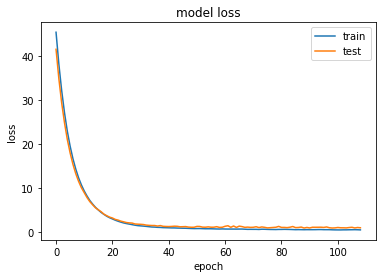

In [228]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Saving the model

In [208]:
# Saving the model.json

import json
model_json = model.to_json()
with open("En_8Class_copy.json", "w") as json_file:
    json_file.write(model_json)

### Loading Model

In [231]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('En_8Class_copy.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model/En_8Class_copy.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 97.00%


In [232]:
x_testcnn.shape

(900, 150, 1)

In [233]:
y_test.shape

(900, 16)

In [234]:
y_train.shape

(2700, 16)

In [235]:
score

[0.5994154654608832, 0.9700000286102295]

In [236]:
print('Train loss', cnnhistory.history['loss'][-1])
print('Test loss', cnnhistory.history['val_loss'][-1])

Train loss 0.5541987303230498
Test loss 1.0271443393495348


In [237]:
print('Train accuracy', cnnhistory.history['accuracy'][-1])
print('Test accuracy', cnnhistory.history['val_accuracy'][-1])

Train accuracy 0.9826389
Test accuracy 0.8374999761581421


In [ ]:
# accuracy: 35.83% --> sr=16000
# accuracy: 28.98% --> sr=22050
# accuracy: 65.42% --> with data Augmented (Noise, Shift, speedNpitch )
# accuracy: 54.37% --> with Scalers and Data Augmented (Noise, Shift, speedNpitch)
# accuracy: 60.42% --> Male sound
# accuracy: 67.40% --> playing with opt & add hiden layer


### Predicting  

In [60]:
# test data 
len(data3_df)

240

In [61]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data3_df))):
    X, sample_rate = librosa.load(data3_df.path[i], res_type='kaiser_fast',sr=16000,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data3_df.label)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

100%|██████████| 240/240 [00:08<00:00, 29.94it/s]


In [62]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

720/720 [==============================] - 1s 827us/step


In [63]:
#preds

In [64]:
preds1=preds.argmax(axis=1)

In [65]:
result = preds1.astype(int).flatten()

In [66]:
predictions = (lb.inverse_transform((result)))

In [67]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf.head(10)

,predictedvalues
0,male_happy
1,male_disgust
2,female_surprised
3,female_surprised
4,female_disgust
5,male_disgust
6,female_disgust
7,female_calm
8,male_calm
9,female_calm


In [68]:
actual=y_test.argmax(axis=1)
actual_result = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((actual_result)))

In [69]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf.head(10)

,actualvalues
0,male_surprised
1,male_disgust
2,female_happy
3,female_surprised
4,female_disgust
5,male_disgust
6,female_happy
7,female_calm
8,male_calm
9,female_calm


In [70]:
finaldf = actualdf.join(preddf)

### Actual vs Predicted emotions

In [71]:
finaldf.head(10)

,actualvalues,predictedvalues
0,male_surprised,male_happy
1,male_disgust,male_disgust
2,female_happy,female_surprised
3,female_surprised,female_surprised
4,female_disgust,female_disgust
5,male_disgust,male_disgust
6,female_happy,female_disgust
7,female_calm,female_calm
8,male_calm,male_calm
9,female_calm,female_calm


In [72]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,48
female_calm,48
female_disgust,48
female_fearful,48
female_happy,48
female_neutral,24
female_sad,48
female_surprised,48
male_angry,48


In [73]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,45
female_calm,58
female_disgust,54
female_fearful,51
female_happy,31
female_neutral,26
female_sad,54
female_surprised,56
male_angry,43


#### confusion_matrix

In [74]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [75]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

85.69444444444444

In [76]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

85.51132575965374

In [77]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)

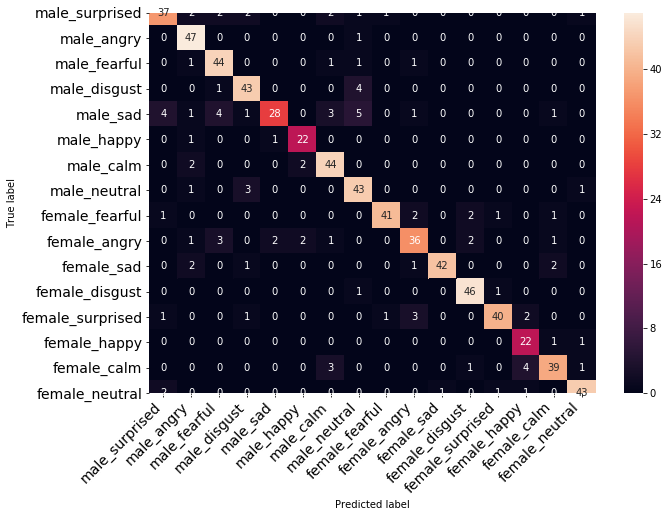

In [78]:
class_names = ['male_surprised', 'male_angry', 'male_fearful', 'male_disgust',
       'male_sad', 'male_happy', 'male_calm', 'male_neutral',
       'female_fearful', 'female_angry', 'female_sad', 'female_disgust',
       'female_surprised', 'female_happy', 'female_calm',
       'female_neutral']
print_confusion_matrix(c, class_names)
plt.savefig('conf_8.png')

# Live Demo 

In [ ]:
# livetest.   sa15.          su15
#22050        16000*2
#3.46         2.39

In [397]:
data, sampling_rate = librosa.load('datasets/livetest.wav')

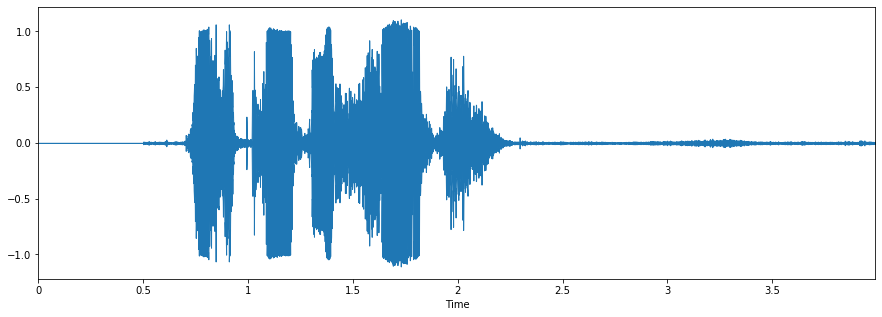

In [398]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)
ipd.Audio('datasets/livetest.wav', rate=sample_rate)

In [399]:

#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('datasets/livetest.wav', res_type='kaiser_fast',duration=2.39,sr=16000*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [400]:
livedf2= pd.DataFrame(data=livedf2)

In [401]:
livedf2 = livedf2.stack().to_frame().T

In [402]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-20.264194,-21.85553,-23.131868,-22.856598,-21.997438,-22.556282,-23.922802,-22.163565,-22.944149,-22.880909,...,-25.756956,-26.188814,-25.275383,-25.062572,-23.587059,-22.516226,-22.698965,-23.559465,-23.316368,-21.941433


In [403]:
twodim= np.expand_dims(livedf2, axis=2)

In [404]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 6ms/step


In [405]:
#livepreds

In [406]:
livepreds1=livepreds.argmax(axis=1)

In [407]:
liveabc = livepreds1.astype(int).flatten()

In [408]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['male_angry'], dtype=object)

# Multi Layer Perceptron Classifier

In [277]:
#Initializing the Multi Layer Perceptron Classifier

from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier(alpha = 0.01, batch_size = 256, epsilon = 1e-08, hidden_layer_sizes = (300,), 
                    learning_rate='adaptive', max_iter = 500)

In [278]:
#Training the model

classifier.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.01, batch_size=256, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(300,), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=500, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [279]:
#Prediction for the test set

y_pred = classifier.predict(X_test)

In [280]:
#Calculating the accuracy of our model

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true = y_test, y_pred = y_pred)

In [281]:
#Printing the accuracy

print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 22.78%


# Logistic Regression

In [162]:
from sklearn.linear_model import LogisticRegression

In [165]:
combined_df.label.value_counts()

female_sad          240
female_surprised    240
male_disgust        240
male_sad            240
male_surprised      240
female_fearful      240
male_calm           240
male_angry          240
female_calm         240
female_angry        240
male_fearful        240
female_happy        240
female_disgust      240
male_happy          240
female_neutral      120
male_neutral        120
Name: label, dtype: int64

In [170]:
df_ = combined_df.copy()

In [295]:
lr = LogisticRegression(solver='lbfgs')
scaler = StandardScaler()

X = df_.drop(['label'], axis = 1) #features
y = df_['label'] #labels

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_trains = scaler.fit_transform(X_train)
X_tests = scaler.transform(X_test)

lr.fit(X_trains, y_train)

/Users/mbuhliagah/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/mbuhliagah/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/mbuhliagah/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/mbuhliagah/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/mbuhliagah/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logi

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [173]:
y_pred = lr.predict(X_tests)

In [174]:
y_test.shape

(900,)

In [265]:
score = lr.score(X_tests, y_pred)
print(score)

1.0


In [184]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

    female_angry       0.36      0.53      0.43        51
     female_calm       0.52      0.52      0.52        61
  female_disgust       0.41      0.34      0.37        59
  female_fearful       0.40      0.47      0.43        66
    female_happy       0.37      0.43      0.40        68
  female_neutral       0.20      0.14      0.16        29
      female_sad       0.36      0.36      0.36        56
female_surprised       0.39      0.43      0.41        65
      male_angry       0.68      0.66      0.67        71
       male_calm       0.50      0.32      0.39        60
    male_disgust       0.46      0.49      0.48        59
    male_fearful       0.32      0.44      0.37        55
      male_happy       0.38      0.26      0.31        58
    male_neutral       0.33      0.14      0.20        29
        male_sad       0.24      0.27      0.25        52
  male_surprised       0.43      0.41      0.42        61

        accu

# Support Vector Machine

In [188]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [189]:
grid = {
    'C': [1, 5, 50],
    'gamma': [0.05, 0.1, 0.5, 1, 5]
}

svm = GridSearchCV(SVC(), grid)
svm.fit(X_train, y_train)

/Users/mbuhliagah/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 5, 50], 'gamma': [0.05, 0.1, 0.5, 1, 5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [190]:
svm.best_params_

{'C': 5, 'gamma': 0.05}

In [191]:
pred_svm = svm.predict(X_test)

print(classification_report(y_test, pred_svm))

                  precision    recall  f1-score   support

    female_angry       0.06      1.00      0.11        51
     female_calm       1.00      0.05      0.09        61
  female_disgust       1.00      0.12      0.21        59
  female_fearful       1.00      0.02      0.03        66
    female_happy       1.00      0.03      0.06        68
  female_neutral       1.00      0.10      0.19        29
      female_sad       1.00      0.07      0.13        56
female_surprised       1.00      0.06      0.12        65
      male_angry       1.00      0.01      0.03        71
       male_calm       1.00      0.05      0.10        60
    male_disgust       1.00      0.03      0.07        59
    male_fearful       1.00      0.05      0.10        55
      male_happy       1.00      0.07      0.13        58
    male_neutral       1.00      0.03      0.07        29
        male_sad       1.00      0.08      0.14        52
  male_surprised       1.00      0.03      0.06        61

        accu

In [269]:
score_svm = svm.score(X_tests, pred_svm)*100
print(score_svm)

95.11111111111111


# Gradient Boosting

In [194]:
from sklearn.ensemble import GradientBoostingClassifier

In [296]:
gb = GradientBoostingClassifier(learning_rate = 0.5, max_depth = 3, n_estimators = 100)
gb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.5, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [196]:
grid = {
    'learning_rate': [0.03, 0.1, 0.5], 
    'n_estimators': [100, 300], 
    'max_depth': [1, 3, 9]
}

gb = GridSearchCV(GradientBoostingClassifier(), grid, verbose = 2)
gb.fit(X_train, y_train)

/Users/mbuhliagah/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] learning_rate=0.03, max_depth=1, n_estimators=100 ...............
[CV]  learning_rate=0.03, max_depth=1, n_estimators=100, total=   5.0s
[CV] learning_rate=0.03, max_depth=1, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s


[CV]  learning_rate=0.03, max_depth=1, n_estimators=100, total=   4.8s
[CV] learning_rate=0.03, max_depth=1, n_estimators=100 ...............
[CV]  learning_rate=0.03, max_depth=1, n_estimators=100, total=   5.0s
[CV] learning_rate=0.03, max_depth=1, n_estimators=300 ...............
[CV]  learning_rate=0.03, max_depth=1, n_estimators=300, total=  14.8s
[CV] learning_rate=0.03, max_depth=1, n_estimators=300 ...............
[CV]  learning_rate=0.03, max_depth=1, n_estimators=300, total=  14.5s
[CV] learning_rate=0.03, max_depth=1, n_estimators=300 ...............
[CV]  learning_rate=0.03, max_depth=1, n_estimators=300, total=  15.7s
[CV] learning_rate=0.03, max_depth=3, n_estimators=100 ...............
[CV]  learning_rate=0.03, max_depth=3, n_estimators=100, total=  17.8s
[CV] learning_rate=0.03, max_depth=3, n_estimators=100 ...............
[CV]  learning_rate=0.03, max_depth=3, n_estimators=100, total=  18.0s
[CV] learning_rate=0.03, max_depth=3, n_estimators=100 ...............
[CV]  

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 28.5min finished
/Users/mbuhliagah/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  pre

In [197]:
gb.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}

In [199]:
gb_pred = gb.predict(X_test)

print(classification_report(y_test, gb_pred))

                  precision    recall  f1-score   support

    female_angry       0.44      0.61      0.51        51
     female_calm       0.60      0.66      0.62        61
  female_disgust       0.57      0.59      0.58        59
  female_fearful       0.55      0.45      0.50        66
    female_happy       0.45      0.43      0.44        68
  female_neutral       0.50      0.38      0.43        29
      female_sad       0.50      0.66      0.57        56
female_surprised       0.61      0.65      0.63        65
      male_angry       0.86      0.68      0.76        71
       male_calm       0.55      0.53      0.54        60
    male_disgust       0.60      0.47      0.53        59
    male_fearful       0.58      0.60      0.59        55
      male_happy       0.50      0.53      0.52        58
    male_neutral       0.38      0.21      0.27        29
        male_sad       0.38      0.54      0.45        52
  male_surprised       0.62      0.49      0.55        61

        accu

In [315]:
score_gb = svm.score(X_tests, gb_pred)
print(score_gb)

0.07888888888888888


In [283]:
###########

In [299]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, .8, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=learning_rate, max_features=16, max_depth=2, random_state=0)
    gb_clf.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    #print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_val, y_val)))

Learning rate:  0.05
Accuracy score (training): 0.435
Learning rate:  0.075
Accuracy score (training): 0.461
Learning rate:  0.1
Accuracy score (training): 0.490
Learning rate:  0.25
Accuracy score (training): 0.605
Learning rate:  0.5
Accuracy score (training): 0.728
Learning rate:  0.75
Accuracy score (training): 0.729
Learning rate:  0.8
Accuracy score (training): 0.718
Learning rate:  1
Accuracy score (training): 0.575


In [301]:
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.75, max_features=2, max_depth=2, random_state=0)
gb_clf2.fit(X_train, y_train)
predictions = gb_clf2.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions))

print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix:
[[12  1  5  8  5  2  5  6  5  2  4  3  7  0  2  1]
 [ 3 26  4  3  1  3 12  5  0  3  0  0  0  0  2  1]
 [ 1  9 24  1  3  1  3  2  0  3  6  0  4  0  1  0]
 [ 2  7  3 17  5  1  7  6  2  1  1  2  5  0  0  4]
 [ 2  3  8  6 16  2  4  2  2  3  2  0  2  0  2  1]
 [ 2  5  0  4  7  6  9  1  0  1  0  0  0  1  0  0]
 [ 2  9  7  1  5  5 18  8  0  0  2  0  0  1  1  1]
 [ 1  2  3  4  6  4  3 16  1  1  1  1  1  0  2  3]
 [ 4  0  0  0  4  0  0  0 31  2  6  3  5  0  1  3]
 [ 2  1  4  0  1  1  1  0  2 18 11  1  2  4  5  8]
 [ 2  0  4  2  1  1  0  2  2  8 10  2  2  3  4  9]
 [ 6  2  0  2  6  0  1  2  7  1  3 19  3  4  3  8]
 [ 2  1  0  1  1  0  1  3 10  5  3  7 13  3  7  7]
 [ 0  0  0  0  0  0  0  0  0  6  2  3  1  2  4 10]
 [ 0  2  0  4  2  1  2  5  1  5  2  2  5  5 18  8]
 [ 0  0  1  0  1  0  1  1  2  7  2  7  3  1  5 24]]
Classification Report
                  precision    recall  f1-score   support

    female_angry       0.29      0.18      0.22        68
     female_calm       0.3

In [305]:
score_gb = gb_clf2.score(X_tests, y_test)*100
print(score_gb)

7.000000000000001


# KNN

In [309]:
from sklearn.neighbors import KNeighborsClassifier

In [310]:
K = [] 
training = [] 
test = [] 
scores = {} 
  
for k in range(2, 21): 
    clf = KNeighborsClassifier(n_neighbors = k) 
    clf.fit(X_train, y_train) 
  
    training_score = clf.score(X_train, y_train) 
    test_score = clf.score(X_test, y_test) 
    K.append(k) 
  
    training.append(training_score) 
    test.append(test_score) 
    scores[k] = [training_score, test_score]

In [311]:
for keys, values in scores.items(): 
    print(keys, ':', values) 

2 : [0.8214814814814815, 0.5122222222222222]
3 : [0.7977777777777778, 0.4588888888888889]
4 : [0.7403703703703703, 0.45]
5 : [0.6903703703703704, 0.4111111111111111]
6 : [0.6411111111111111, 0.4066666666666667]
7 : [0.6081481481481481, 0.38555555555555554]
8 : [0.5762962962962963, 0.3711111111111111]
9 : [0.5418518518518518, 0.3622222222222222]
10 : [0.5274074074074074, 0.36333333333333334]
11 : [0.5111111111111111, 0.36444444444444446]
12 : [0.4922222222222222, 0.36444444444444446]
13 : [0.47814814814814816, 0.3611111111111111]
14 : [0.4685185185185185, 0.36333333333333334]
15 : [0.45666666666666667, 0.36]
16 : [0.45037037037037037, 0.35333333333333333]
17 : [0.44407407407407407, 0.3655555555555556]
18 : [0.44, 0.3611111111111111]
19 : [0.43407407407407406, 0.3566666666666667]
20 : [0.4351851851851852, 0.3566666666666667]


In [314]:
clf.score(X_tests, y_test)

0.06555555555555556